In [345]:
import augraphy
import matplotlib.pyplot as plt
import numpy as np

In [346]:
import cv2

In [347]:
from augraphy import *

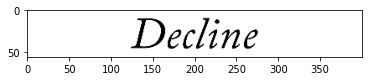

In [348]:
# used to augment
image = cv2.imread("./italic.png")

# for comparison
orignal_image = cv2.imread("./italic.png")

# since image is already grayscale we need only single channel
# (others are already same as 1st)

image = image[:,:,0]


plt.imshow(image,cmap='gray')

In [349]:
# p noise function

def p_noise(image, prob):
    '''
    Add pepper noise to image
    prob: Probability of the noise
    '''
    output = image.copy()
    if len(image.shape) == 2:
        black = 0         
    else:
        colorspace = image.shape[2]
        if colorspace == 3:  # RGB
            black = np.array([0, 0, 0], dtype='uint8')
        else:  # RGBA
            black = np.array([0, 0, 0, 255], dtype='uint8')
    probs = np.random.random(output.shape[:2])
    
    # 1/6 chance of pepper noise to occur
    output[probs < (prob / 4)] = black
    return output

<h1>Pipeline</h1>

<h2>Using Laplacian and p_noise edge noising</h2>

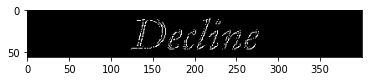

In [350]:
# laplacian
kernel_size = 3
dst = cv2.Laplacian(image,ddepth=cv2.CV_16S,ksize=kernel_size)
intmediate = np.clip(dst,0,255)

# thresholding of intermediate
intmediate[intmediate>=200] = 255
intmediate[intmediate<100] = 0

# to find one pixel extra boundary thick layer (both sides) of edge we do dilation 
# and subtract the orignal mask from it

kernel = np.ones((2, 2), np.uint8)
temp_image = cv2.dilate(intmediate, kernel, iterations=1)
new_output = temp_image - intmediate

# adding noise
new_output = p_noise(new_output,1)

# final mask with noise is new_output
plt.imshow(new_output,cmap='gray')

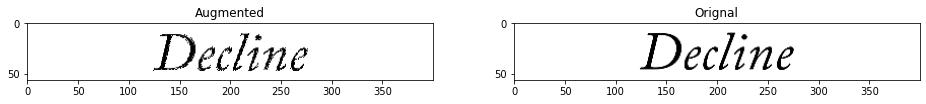

In [351]:
# erode the image to retain the size for taking the extra boundary

# binary invert the image
temporary_switch = 1
image[image==255] = temporary_switch
image[image==0] = 255
image[image==temporary_switch] = 0

kernel = np.ones((2, 2), np.uint8)
image = cv2.erode(image, kernel, iterations=1)

# binary restore the image
temporary_switch = 1
image[image==255] = temporary_switch
image[image==0] = 255
image[image==temporary_switch] = 0

# basically there is 
image[new_output==255] = 0

fig,axs = plt.subplots(1,2,figsize=(16,5))
axs[0].imshow(image,cmap='gray')

axs[0].set_title('Augmented')

axs[1].imshow(orignal_image)
axs[1].set_title('Orignal')

plt.show()

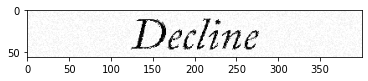

In [352]:
"""
AUGRAPHY ENTERS THE PICTURE !

"""
# apply subtle noise to give a real image effect with no exactly white corner
subtle_noise = SubtleNoise(subtle_range=20)
img_subtle_noise = subtle_noise(image)

plt.imshow(img_subtle_noise,cmap='gray')

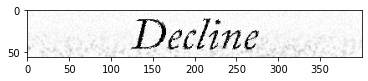

In [353]:
# Bad photocopy for scanner noise

BadPhotoCopy_type_1 = BadPhotoCopy(noise_type=1,
                                   noise_side="random",
                                   noise_iteration=(1,1),
                                   noise_size=(1,2),
                                   noise_sparsity=(0.6,0.9),
                                   noise_concentration=(0.1,0.3),
                                   blur_noise=-1,
                                   blur_noise_kernel=(5,5),
                                   wave_pattern=0,
                                   edge_effect=0)
img_BadPhotoCopy_type_1 = BadPhotoCopy_type_1(img_subtle_noise)
plt.imshow(img_BadPhotoCopy_type_1,cmap='gray')

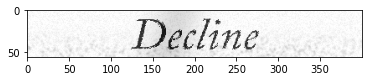

In [354]:
# apply lights to the corresponding image for light rays angle

lighting_gradient_gaussian = LightingGradient(light_position=None,
                                              direction=75,
                                              max_brightness=170,
                                              min_brightness=0,
                                              transparency=0.8
                                              )
img_lighting_gradient_gaussian =  lighting_gradient_gaussian(img_BadPhotoCopy_type_1)
plt.imshow(img_lighting_gradient_gaussian)

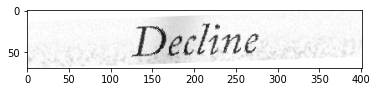

In [355]:
# applying rotation as a basic affine transformation

geometric = Geometric(scale=(1, 1),
                      translation=(0, 0),
                      fliplr=0,
                      flipud=0,
                      rotate_range=(-3, -1)and (1,3)
                      )

img_geometric_transform = geometric(img_lighting_gradient_gaussian)

BadPhotoCopy_type_2 = BadPhotoCopy(noise_type=1,
                                   noise_side="random",
                                   noise_iteration=(1,1),
                                   noise_size=(1,2),
                                   noise_sparsity=(0.6,0.9),
                                   noise_concentration=(0.1,0.3),
                                   blur_noise=-1,
                                   blur_noise_kernel=(5,5),
                                   wave_pattern=0,
                                   edge_effect=0)
img_BadPhotoCopy_type_2 = BadPhotoCopy_type_2(img_geometric_transform)


plt.imshow(img_geometric_transform,cmap='gray')

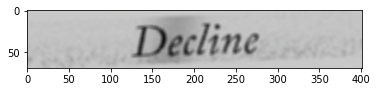

In [356]:
# apply low light noise (extra but not a very nice one !)

lowlightnoise_obj = LowLightNoise(
    num_photons_range = (5, 10),
    alpha_range = (0.6, 1),
    beta_range = (1, 2),
    gamma_range = (1 , 2)
)

lowlightnoise_img = lowlightnoise_obj(img_geometric_transform)
plt.imshow(lowlightnoise_img,cmap='gray')